# DNSSEC Crypto Support in Domains on the Internet

## Imports

In [1]:
import json
import re
import pandas as pd
import numpy as np
# from dns import message
from dns import rdata
import matplotlib as plt
import seaborn as sns
import logging

## Global Config

In [2]:
logging.basicConfig(level=logging.INFO)
logging.getLogger('matplotlib.font_manager').disabled = True
pd.options.plotting.backend = 'matplotlib'
plt.style.use('ggplot')
# %matplotlib inline
# plt.rcParams["figure.figsize"] = [16, 10]

## Constants

### Data Locations

In [3]:
REPO_DIR = '../../dnssec-downgrade-data/'
DATA_DIR = REPO_DIR + '/2021-06-22_ds-dnskey/'  # location of input/raw and processed data
STATS_DIR = DATA_DIR + '/stats/' # output location fo tables and plots 
TOP100K_FILENAME = DATA_DIR + '/top-100k.csv'
TLDS_FILENAME = DATA_DIR + '/tlds-enum.csv'

JSONL_FILENAME_TOP100K_DS = DATA_DIR + '/top100k-ds.json'
JSONL_FILENAME_TOP100K_DNSKEY = DATA_DIR + '/top100k-dnskey.json'
JSONL_FILENAME_TLDS_DS =  DATA_DIR + '/tlds-ds.json'
JSONL_FILENAME_TLDS_DNSKEY =  DATA_DIR + '/tlds-dnskey.json'

DRILL_OUT_FILENAME_TOP100K =  DATA_DIR + '/top100k-drill-out.txt'
DRILL_OUT_FILENAME_TLDS =  DATA_DIR + '/tlds-drill-out.txt'


### DNS Value Mappings

In [4]:
_ = """
ALGORITHM_NUM_TO_NAME = {
    "0": "DELETE",
    "1": "RSAMD5",
    "2": "DH",
    "3": "DSA",
    "5": "RSASHA1",
    "6": "DSA-NSEC3-SHA1",
    "7": "RSASHA1-NSEC3-SHA1",
    "8": "RSASHA256",
    "10": "RSASHA512",
    "12": "ECC-GOST",
    "13": "ECDSAP256SHA256",
    "14": "ECDSAP384SHA384",
    "15": "ED25519",
    "16": "ED448",
    "252": "INDIRECT",
    "253": "PRIVATEDNS",
    "254": "PRIVATEOID",
    "255": "RESERVED",
}
"""

ALGO_NUM_TO_NAME = {
    0: 'delete',
    1: 'rsamd5',
    2: 'dh',
    3: 'dsa',
    5: 'rsasha1',
    6: "dsansec3sha1",
    7: 'rsasha1nsec3sha1', 
    8: 'rsasha256', 
    10: 'rsasha512',
    12: 'eccgost',
    13: 'ecdsap256sha256', 
    14: 'ecdsap384sha384', 
    15: 'ed25519', 
    16: 'ed448',
    252: "indirect",
    253: "privatedns",
    254: "privateoid",
    255: "reserved",
}
ALGO_NAME_TO_NUM = {name: num for num, name in ALGO_NUM_TO_NAME.items()}

DIGEST_TYPE_NUM_TO_NAME = {
    "0": "RESERVED",
    "1": "SHA-1",
    "2": "SHA256",
    "3": "GOST_R_34.11-94",
    "4": "SHA-384",
}

# Lazy Lower-Definition for integration with existing code
# for k in ALGORITHM_NUM_TO_NAME.keys():
#    ALGORITHM_NUM_TO_NAME[k] = ALGORITHM_NUM_TO_NAME[k].lower()
    
for k in DIGEST_TYPE_NUM_TO_NAME.keys():
    DIGEST_TYPE_NUM_TO_NAME[k] = DIGEST_TYPE_NUM_TO_NAME[k].lower()

### Drill-Interfacing

In [5]:
RTYPE_DNSKEY = "DNSKEY"
RTYPE_DS = "DS"
LINE_PREFIX_SHA1 = '; sha1: '
LINE_PREFIX_SHA256 = '; sha256: '

### Data Structure Constants

In [6]:
RDATA_KEY_DS_KEY_TAG = "key_tag"
RDATA_KEY_DS_ALGORITHM = "algorithm"
RDATA_KEY_DS_DIGEST_TYPE = "digest_type"
RDATA_KEY_DS_DIGEST = "digest"

OUT_KEY_OWNER = "owner_name"
OUT_KEY_RTYPE = "rtype"
OUT_KEY_RCLASS = "rclass"
OUT_KEY_TTL = "ttl"
OUT_KEY_RDATA = "rdata"

RDATA_KEY_DNSKEY_ALGORITHM = "algorithm"
RDATA_KEY_DNSKEY_FLAGS = "flags"
RDATA_KEY_DNSKEY_PROTOCOL = "protocol"
RDATA_KEY_DNSKEY_PUBLIC_KEY = "public_key"
RDATA_KEY_DNSKEY_SPECIAL_ID = "spec_id"
RDATA_KEY_DNSKEY_SPECIAL_LENGTH = "spec_key_length"
RDATA_KEY_DNSKEY_SPECIAL_USAGE = "spec_usage"
RDATA_KEY_RDATA_DCT = 'rdata'

## Data Structure Reference

In [7]:
_ = """
{
    owner_name: "example.org",
    rtype: "DNSKEY",
    rclass: "IN",
    ttl: 42,
    rdata: {  # [probably] flattened!
        flags: 256,
        protocol: 3,
        algorithm: "...",
        public_key: "..."
        spec_key_length_bits: 42,
        spec_usage: "zsk",
        spec_id: 1337
    }
}
"""
_ = """
{
    owner_name: "example.org",
    rtype: "DS",
    rclass: "IN",
    ttl: 42,
    rdata: {  # [probably] flattened!
        key_tag: "...",
        algorithm: "...",
        digest_type: "...",
        digest: "..."
    }
}
"""


## Program Logic

### Parsing and Transformations

In [8]:
def halfparsed_to_json(owner, ttl, rcls, rty, rdata_str):
    dct = dict()
    dct[OUT_KEY_OWNER] = owner
    dct[OUT_KEY_TTL] = ttl
    dct[OUT_KEY_RCLASS] = rcls
    dct[OUT_KEY_RTYPE] = rty
    # dct[RDATA_KEY_RDATA_DCT] = dict()
    # rdct = dct[RDATA_KEY_RDATA_DCT]
    rdct = dct
    if rty.lower() == RTYPE_DNSKEY.lower():
        common_part, special_part = rdata_str.split(';')
        common_part = common_part.strip()

        flags_num, protocol_num, algo_num, pubkey_b64 = common_part.split(" ")
        algo_name = ALGO_NUM_TO_NAME[int(algo_num)]

        special_part_id, special_part_size = special_part.split(",")
        _, _, id, usage = special_part_id.split(" ")
        usage = usage[1:-1]
        key_length = special_part_size.split(" ")[3][:-2]

        rdct[RDATA_KEY_DNSKEY_ALGORITHM] = algo_name
        rdct[RDATA_KEY_DNSKEY_FLAGS] = flags_num
        rdct[RDATA_KEY_DNSKEY_PROTOCOL] = protocol_num
        rdct[RDATA_KEY_DNSKEY_PUBLIC_KEY] = pubkey_b64
        rdct[RDATA_KEY_DNSKEY_SPECIAL_ID] = id
        rdct[RDATA_KEY_DNSKEY_SPECIAL_LENGTH] = key_length
        rdct[RDATA_KEY_DNSKEY_SPECIAL_USAGE] = usage
    elif rty.lower() == RTYPE_DS.lower():
        key_tag, algo_num, digest_type_num, digest_hex = rdata_str.split(" ")
        algo_name = ALGO_NUM_TO_NAME[int(algo_num)]
        digest_type_name = DIGEST_TYPE_NUM_TO_NAME[digest_type_num]

        rdct[RDATA_KEY_DS_KEY_TAG] = key_tag
        rdct[RDATA_KEY_DS_ALGORITHM] = algo_name
        rdct[RDATA_KEY_DS_DIGEST_TYPE] = digest_type_name
        rdct[RDATA_KEY_DS_DIGEST] = digest_hex
    else:
        dct = None
    return dct


def parse_line(line):
    if line is None or line.startswith(";;") or len(line.strip()) == 0:
        return None
    line = line.strip()
    if line.startswith(";"):
        if line.startswith(LINE_PREFIX_SHA1):
            line = line.replace(LINE_PREFIX_SHA1, "")
        elif line.startswith(LINE_PREFIX_SHA256):
            line = line.replace(LINE_PREFIX_SHA256, "")
        else:
            return None
    splits = re.split(r'\s+', line)
    owner, ttl, rcls, rty, rdat_str = splits[0], splits[1], splits[2], splits[3], ' '.join(splits[4:])
    # if rty.lower() == "DNSKEY".lower(): print(line)
    dct = halfparsed_to_json(owner, ttl, rcls, rty, rdat_str)
    return dct


def transform_drill(infile_name, outfile_name_ds, outfile_name_dnskey):
    with open(infile_name, 'r') as infile, \
    open(outfile_name_ds, 'w') as outfile_ds, \
    open(outfile_name_dnskey, 'w') as outfile_dnskey:
        for line in infile:
            dct = parse_line(line)
            if dct is not None:
                if dct[OUT_KEY_RTYPE] == RTYPE_DNSKEY:
                    outfile_dnskey.write(json.dumps(dct) + "\n")
                elif dct[OUT_KEY_RTYPE] == RTYPE_DS:
                    outfile_ds.write(json.dumps(dct) + "\n")


## Data Analysis

### Load Domain Data

In [9]:

DOMAINS_COL_NAME_DOMAIN = "domain"
DOMAINS_COL_NAME_RANK = 'rank'

pdf_tlds = pd.read_csv(TLDS_FILENAME, header=None, names=[DOMAINS_COL_NAME_RANK, DOMAINS_COL_NAME_DOMAIN])
pdf_tlds = pdf_tlds[['domain']]
pdf_tlds['domain'] = pdf_tlds['domain'].apply(lambda x: x + "." if not x.endswith(".") else x)
pdf_top100k = pd.read_csv(TOP100K_FILENAME, header=None, names=[DOMAINS_COL_NAME_RANK, DOMAINS_COL_NAME_DOMAIN])
pdf_top100k['domain'] = pdf_top100k['domain'].apply(lambda x: x + "." if not x.endswith(".") else x)
pdf_top100k

,rank,domain
0,1,google.com.
1,2,youtube.com.
2,3,facebook.com.
3,4,microsoft.com.
4,5,netflix.com.
...,...,...
99995,99996,santamonicapier.org.
99996,99997,gourmetads.com.
99997,99998,guazi.com.
99998,99999,loeildelaphotographie.com.


### Load Crypto Record Data

In [10]:
# Parse Drill output (partially) to JSON (files)
transform_drill(DRILL_OUT_FILENAME_TOP100K, JSONL_FILENAME_TOP100K_DS, JSONL_FILENAME_TOP100K_DNSKEY)
transform_drill(DRILL_OUT_FILENAME_TLDS, JSONL_FILENAME_TLDS_DS, JSONL_FILENAME_TLDS_DNSKEY)

In [11]:
pdf_top100k_dnskey = pd.read_json(JSONL_FILENAME_TOP100K_DNSKEY, orient="records", lines=True)
pdf_tlds_dnskey = pd.read_json(JSONL_FILENAME_TLDS_DNSKEY, orient="records", lines=True)
pdf_top100k_dnskey

,owner_name,ttl,rclass,rtype,algorithm,flags,protocol,public_key,spec_id,spec_key_length,spec_usage
0,europa.eu.,313,IN,DNSKEY,rsasha256,256,3,AwEAAaRm9SpK2QM+wXxIeLqn3YvFZTl7eZM9vTgV4jbMIj...,61458,2048,zsk
1,europa.eu.,313,IN,DNSKEY,rsasha256,256,3,AwEAAbzwGZE2vZI6TKx32QmwUnsHtda7/6BOcNQPeJOLJU...,30858,2048,zsk
2,europa.eu.,313,IN,DNSKEY,rsasha256,257,3,AwEAAd6ILwCObzteZw4iDDFF5Ab0GGaEvtogmEvjNeZyjc...,14845,4096,ksk
3,nih.gov.,5702,IN,DNSKEY,rsasha1nsec3sha1,256,3,AwEAAbN3M1UHyllUVouAT7wMqO6CRhSbFzXf+2iWyecCfv...,32615,1024,zsk
4,nih.gov.,5702,IN,DNSKEY,rsasha1nsec3sha1,256,3,AwEAAfZmlMD7MzozFDRg1/V84TUDiWWh9mmVw4H9Iuc9Ax...,11360,1024,zsk
...,...,...,...,...,...,...,...,...,...,...,...
12831,munpia.com.,3278,IN,DNSKEY,ecdsap256sha256,256,3,oJMRESz5E4gYzS/q6XDrvU1qMPYIjCWzJaOau8XNEZeqCY...,34505,256,zsk
12832,dingoland.ir.,3600,IN,DNSKEY,ecdsap256sha256,257,3,mdsswUyr3DPW132mOi8V9xESWE8jTo0dxCjjnopKl+GqJx...,2371,256,ksk
12833,dingoland.ir.,3600,IN,DNSKEY,ecdsap256sha256,256,3,oJMRESz5E4gYzS/q6XDrvU1qMPYIjCWzJaOau8XNEZeqCY...,34505,256,zsk
12834,loeildelaphotographie.com.,8463,IN,DNSKEY,rsasha1nsec3sha1,256,3,AwEAAcm2N3UWtpuyUdkMgAv4wDvBpCQ6XKDgKSto8VqgaB...,13802,1024,zsk


In [12]:
pdf_top100k_ds = pd.read_json(JSONL_FILENAME_TOP100K_DS, orient="records", lines=True)
pdf_tlds_ds = pd.read_json(JSONL_FILENAME_TLDS_DS, orient="records", lines=True)
pdf_top100k_ds

,owner_name,ttl,rclass,rtype,key_tag,algorithm,digest_type,digest
0,europa.eu.,313,IN,DS,61458,rsasha256,sha-1,8971bf46790fb179b2920302265de1624a1638ff
1,europa.eu.,313,IN,DS,61458,rsasha256,sha256,66b84cdefb7ce0aa0a55661e995b265947df6943fd935b...
2,europa.eu.,313,IN,DS,30858,rsasha256,sha-1,a408c458b500ae3d8fc826874188bc55c7de0218
3,europa.eu.,313,IN,DS,30858,rsasha256,sha256,0255ebf9c1a149a2239a40cca4dc36929f1e2a48b7646f...
4,europa.eu.,313,IN,DS,14845,rsasha256,sha-1,a59494c968c2a74161205252f5c66c08d3da50bd
...,...,...,...,...,...,...,...,...
25667,dingoland.ir.,3600,IN,DS,34505,ecdsap256sha256,sha256,d110409611e47f58fcb2768fee55b0e56920f254218875...
25668,loeildelaphotographie.com.,8463,IN,DS,13802,rsasha1nsec3sha1,sha-1,3d9a8649479e90fa254821480767c4e078b70611
25669,loeildelaphotographie.com.,8463,IN,DS,13802,rsasha1nsec3sha1,sha256,63e2b42218c7ac8f963e96471cfaf7fba9b97ebf613148...
25670,loeildelaphotographie.com.,8463,IN,DS,6378,rsasha1nsec3sha1,sha-1,a57cef886c18ad3b85723e89a9ebd199fdf9b188


### Analyze Crypto Record Data

#### Share of DNSSEC-Protected Domains

In [13]:
joined_pdf_top100k_dnskey = pd.merge(left=pdf_top100k_dnskey, right=pdf_top100k, how='right', left_on='owner_name', right_on='domain')
joined_pdf_tlds_dnskey = pd.merge(left=pdf_tlds_dnskey, right=pdf_tlds, how='right', left_on='owner_name', right_on='domain')
print("Top100k: {}\n".format(len(pdf_top100k)) + str(joined_pdf_top100k_dnskey['rtype'].value_counts(dropna=False)))
print("\nTLDs: {}\n".format(len(pdf_tlds)) + str(joined_pdf_tlds_dnskey['rtype'].value_counts(dropna=False)))
# joined_pdf_tlds_dnskey[joined_pdf_tlds_dnskey['rtype'].isnull()]['domain']

Top100k: 100000
NaN       94275
DNSKEY    12836
Name: rtype, dtype: int64

TLDs: 1498
DNSKEY    3548
NaN        118
Name: rtype, dtype: int64


#### Absolute Occurrencees of Algorithms in the Dataset
*each DNSKEY record counts*

In [14]:
algo_count_top100k_dnskey = pdf_top100k_dnskey['algorithm'].value_counts().to_frame()
algo_count_tlds_dnskey = pdf_tlds_dnskey['algorithm'].value_counts().to_frame()

print("TLDs:")
print(algo_count_tlds_dnskey.to_string())
print("\nTop100k:\n" + str(algo_count_top100k_dnskey))
# type(algo_count_tlds_dnskey)

algo_count_combined_dnskey = algo_count_top100k_dnskey.join(algo_count_tlds_dnskey, how='outer', lsuffix='t100', rsuffix='tlds')
algo_count_combined_dnskey.columns=["Top100K", "TLDs"]
algo_count_combined_dnskey['TLDs'] = algo_count_combined_dnskey['TLDs'].fillna(0).astype(int)

# Store away absolutes for processing in a different notebook
algo_count_combined_dnskey.to_csv(STATS_DIR + "/algo_freq_combined_dnskey.csv", index_label="Algorithm")

# print(algo_count_combined_dnskey.to_latex())
algo_count_combined_dnskey

TLDs:
                  algorithm
rsasha256              3145
rsasha1nsec3sha1        159
ecdsap256sha256          90
rsasha1                  87
rsasha512                67

Top100k:
                  algorithm
ecdsap256sha256        6725
rsasha256              4081
rsasha1nsec3sha1       1160
rsasha1                 574
rsasha512               226
ecdsap384sha384          65
privatedns                4
dsa                       1


,Top100K,TLDs
dsa,1,0
ecdsap256sha256,6725,90
ecdsap384sha384,65,0
privatedns,4,0
rsasha1,574,87
rsasha1nsec3sha1,1160,159
rsasha256,4081,3145
rsasha512,226,67


#### Relative Occurences in the Dataset
*each DNSKEY counts*

In [15]:

algo_freq_combined_dnskey = algo_count_combined_dnskey.copy(deep=True)
# algo_freq_combined_dnskey['Top100K'] = algo_freq_combined_dnskey['Top100K']/sum(algo_freq_combined_dnskey['Top100K'])
# algo_freq_combined_dnskey['TLDs'] = algo_freq_combined_dnskey['TLDs']/sum(algo_freq_combined_dnskey['TLDs'])
# algo_freq_combined_dnskey.sort_values(by=["Top100K", "TLDs"], ascending=True, inplace=True)

# Remove Uninteresting Algorithms
algo_freq_combined_dnskey.sort_index(ascending=True, inplace=True)
algo_freq_combined_dnskey.drop(axis=0, index=['dsa', 'privatedns'], inplace=True)

# normalize over total occurrences of all algorithms
algo_freq_combined_dnskey['Top100K'] = algo_freq_combined_dnskey['Top100K']/sum(algo_freq_combined_dnskey['Top100K'])
algo_freq_combined_dnskey['TLDs'] = algo_freq_combined_dnskey['TLDs']/sum(algo_freq_combined_dnskey['TLDs'])


algo_freq_combined_dnskey

# agc_t100k_dnskey_plt = algo_count_top100k_dnskey.plot.pie(y='algorithm', figsize=(10, 5))
# agc_tlds_dnskey_plt = algo_count_tlds_dnskey.plot.pie(subplots=True, figsize=(10, 5))

,Top100K,TLDs
ecdsap256sha256,0.524121,0.025366
ecdsap384sha384,0.005066,0.000000
rsasha1,0.044735,0.024521
rsasha1nsec3sha1,0.090406,0.044814
rsasha256,0.318058,0.886415
rsasha512,0.017614,0.018884


##### Cumulative

In [16]:
algo_freq_combined_dnskey_cdf = algo_freq_combined_dnskey.copy(deep=True)
algo_freq_combined_dnskey_cdf['Top100K'] = algo_freq_combined_dnskey_cdf['Top100K'].cumsum()
algo_freq_combined_dnskey_cdf['TLDs'] = algo_freq_combined_dnskey_cdf['TLDs'].cumsum()
algo_freq_combined_dnskey_cdf

,Top100K,TLDs
ecdsap256sha256,0.524121,0.025366
ecdsap384sha384,0.529187,0.025366
rsasha1,0.573923,0.049887
rsasha1nsec3sha1,0.664329,0.094701
rsasha256,0.982386,0.981116
rsasha512,1.000000,1.000000


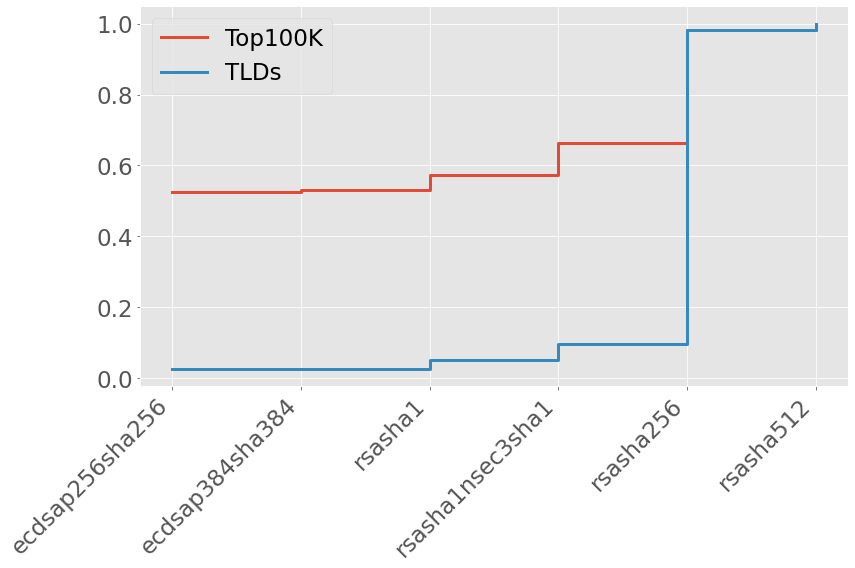

In [17]:
algo_freq_combined_dnskey_cdf_plot = algo_freq_combined_dnskey_cdf.plot.line(drawstyle='steps-post', subplots=False, sharex=True, sharey=True, fontsize=23, linewidth=3, figsize=(12,8))
algo_freq_combined_dnskey_cdf_plot.legend(loc=2, prop={'size': 23})

algo_freq_combined_dnskey_cdf_plot.set_xticklabels(algo_freq_combined_dnskey_cdf_plot.get_xticklabels(), rotation = 45, ha="right")
algo_freq_combined_dnskey_cdf_plot.get_figure().tight_layout()
algo_freq_combined_dnskey_cdf_plot.get_figure().savefig(STATS_DIR + '/algo_freq_combined_dnskey_cdf_plot.pdf', format='pdf')

In [18]:
%%script false --no-raise-error
# agc_tlds_dnskey_plt = algo_count_tlds_dnskey.plot.pie(y='algorithm', figsize=(5, 5))#, figsize=(20, 10), fontsize=12)
# agc_t100k_dnskey_plt = algo_count_top100k_dnskey.plot.pie(subplots=True, figsize=(11, 6))
algo_count_combined_dnskey.plot.pie(subplots=True, figsize=(15, 10))

### RSA Key Lengths in Domains

#### Recall Original Datasets

In [19]:
pdf_top100k_dnskey

,owner_name,ttl,rclass,rtype,algorithm,flags,protocol,public_key,spec_id,spec_key_length,spec_usage
0,europa.eu.,313,IN,DNSKEY,rsasha256,256,3,AwEAAaRm9SpK2QM+wXxIeLqn3YvFZTl7eZM9vTgV4jbMIj...,61458,2048,zsk
1,europa.eu.,313,IN,DNSKEY,rsasha256,256,3,AwEAAbzwGZE2vZI6TKx32QmwUnsHtda7/6BOcNQPeJOLJU...,30858,2048,zsk
2,europa.eu.,313,IN,DNSKEY,rsasha256,257,3,AwEAAd6ILwCObzteZw4iDDFF5Ab0GGaEvtogmEvjNeZyjc...,14845,4096,ksk
3,nih.gov.,5702,IN,DNSKEY,rsasha1nsec3sha1,256,3,AwEAAbN3M1UHyllUVouAT7wMqO6CRhSbFzXf+2iWyecCfv...,32615,1024,zsk
4,nih.gov.,5702,IN,DNSKEY,rsasha1nsec3sha1,256,3,AwEAAfZmlMD7MzozFDRg1/V84TUDiWWh9mmVw4H9Iuc9Ax...,11360,1024,zsk
...,...,...,...,...,...,...,...,...,...,...,...
12831,munpia.com.,3278,IN,DNSKEY,ecdsap256sha256,256,3,oJMRESz5E4gYzS/q6XDrvU1qMPYIjCWzJaOau8XNEZeqCY...,34505,256,zsk
12832,dingoland.ir.,3600,IN,DNSKEY,ecdsap256sha256,257,3,mdsswUyr3DPW132mOi8V9xESWE8jTo0dxCjjnopKl+GqJx...,2371,256,ksk
12833,dingoland.ir.,3600,IN,DNSKEY,ecdsap256sha256,256,3,oJMRESz5E4gYzS/q6XDrvU1qMPYIjCWzJaOau8XNEZeqCY...,34505,256,zsk
12834,loeildelaphotographie.com.,8463,IN,DNSKEY,rsasha1nsec3sha1,256,3,AwEAAcm2N3UWtpuyUdkMgAv4wDvBpCQ6XKDgKSto8VqgaB...,13802,1024,zsk


In [20]:
pdf_tlds_dnskey

,owner_name,ttl,rclass,rtype,algorithm,flags,protocol,public_key,spec_id,spec_key_length,spec_usage
0,aaa.,3069,IN,DNSKEY,rsasha256,256,3,AwEAAaZo2PfcnuHG+fTtOv+dlGmcaXMx9nnTZADUdZ0DiM...,20983,1024,zsk
1,aaa.,3069,IN,DNSKEY,rsasha256,256,3,AwEAAb12rqjDMXPoWc8Dy27iQL8yXUFG0RcofgFqtY1jb6...,13510,1024,zsk
2,aaa.,3069,IN,DNSKEY,rsasha256,256,3,AwEAAcE8Hq2/8vrhkGEoGAzjrOg1hOT7Dw5tXdZUPIBCYa...,1569,1280,zsk
3,aaa.,3069,IN,DNSKEY,rsasha256,256,3,AwEAAcLnWJQH2nFnnjdwKr4pNSRQQrU300nt3BxCfxGZqk...,44908,1024,zsk
4,aaa.,3069,IN,DNSKEY,rsasha256,257,3,AwEAAdP0u7lPitKr5iXKatPvzmQzp4lYfJulzSwF6aNH5N...,1657,2048,ksk
...,...,...,...,...,...,...,...,...,...,...,...
3543,zone.,76674,IN,DNSKEY,rsasha256,256,3,AwEAAaQDRs2XhuvJFlXxo0DsLIke4DOnK3LyEKpF8oZ1qo...,29769,1280,zsk
3544,zuerich.,3432,IN,DNSKEY,rsasha256,256,3,AwEAAc2MJ1mM4LvbmGkZq6wZe0rH3PV7tggp3A4XnGmOK0...,1189,1024,zsk
3545,zuerich.,3432,IN,DNSKEY,rsasha256,256,3,AwEAAdU/H1bShRjgpkoBudUbHtYeju9UcKtoZsIzUAyFyp...,56983,1024,zsk
3546,zuerich.,3432,IN,DNSKEY,rsasha256,256,3,AwEAAecOdYiObn9+R3bM2GlY1w4zw4TQslWIRpwpQtygjI...,13819,1024,zsk


#### Boil down original Datasets to the required columns

In [21]:
pdf_top100k_dnskey_all = pdf_top100k_dnskey.copy(deep=True)[['owner_name', 'algorithm', 'spec_key_length']]
pdf_tlds_dnskey_all = pdf_tlds_dnskey.copy(deep=True)[['owner_name', 'algorithm', 'spec_key_length']]


#### Filter for RSA Algorithms

In [22]:
pdf_top100k_dnskey_rsa = pdf_top100k_dnskey_all[pdf_top100k_dnskey_all['algorithm'].str.startswith('rsa')]
pdf_tlds_dnskey_rsa = pdf_tlds_dnskey_all[pdf_tlds_dnskey_all['algorithm'].str.startswith('rsa')]
pdf_top100k_dnskey_rsa

,owner_name,algorithm,spec_key_length
0,europa.eu.,rsasha256,2048
1,europa.eu.,rsasha256,2048
2,europa.eu.,rsasha256,4096
3,nih.gov.,rsasha1nsec3sha1,1024
4,nih.gov.,rsasha1nsec3sha1,1024
...,...,...,...
12823,wot-life.com.,rsasha1nsec3sha1,2048
12828,parasoft.com.,rsasha512,4096
12829,parasoft.com.,rsasha512,4096
12834,loeildelaphotographie.com.,rsasha1nsec3sha1,1024


#### Filter for Key Length LE 1024
*intermediary step only for interest*

In [51]:
pdf_top100k_dnskey_rsa_le1024 = pdf_top100k_dnskey_rsa[pdf_top100k_dnskey_rsa['spec_key_length'] <= 1023]
pdf_tlds_dnskey_rsa_le1024 = pdf_tlds_dnskey_rsa[pdf_tlds_dnskey_rsa['spec_key_length'] <= 1024]
# pdf_top100k_dnskey_rsa_keylengths = pdf_top100k_dnskey_rsa[['spec_key_length']].value_counts()
pdf_top100k_dnskey_rsa_le1024

,owner_name,algorithm,spec_key_length
1488,incapdns.net.,rsasha256,512
1489,incapdns.net.,rsasha256,512
1588,simon.com.,rsasha256,512
1589,simon.com.,rsasha256,512
2275,premiumoutlets.com.,rsasha256,512
2276,premiumoutlets.com.,rsasha256,512
2490,itamaraty.gov.br.,rsasha1,512
2491,itamaraty.gov.br.,rsasha1,512
2895,cphpost.dk.,rsasha1,512
2896,cphpost.dk.,rsasha1,512


#### Extract Basic Statistics

In [24]:
print("Number of Top100k domains without any DNSKEY:", joined_pdf_top100k_dnskey[joined_pdf_top100k_dnskey['algorithm'].isnull()]['domain'].nunique())
print("Number of Top100k domains with any DNSKEY:", pdf_top100k_dnskey_all[pdf_top100k_dnskey_all['algorithm'].notnull()]['owner_name'].nunique())
print("Number of Top100k domains with RSA DNSKEY:", pdf_top100k_dnskey_rsa['owner_name'].nunique())
print("Domains having RSA Key Length <= RSSA1024: {}".format(pdf_top100k_dnskey_rsa_le1024['owner_name'].nunique()))

print("Number of TLDs without any DNSKEY:", joined_pdf_tlds_dnskey[joined_pdf_tlds_dnskey['algorithm'].isnull()]['domain'].nunique())
print("Number of TLDs with any DNSKEY:", pdf_tlds_dnskey_all[pdf_tlds_dnskey_all['algorithm'].notnull()]['owner_name'].nunique())
print("Number of TLDs with RSA DNSKEY:", pdf_tlds_dnskey_rsa['owner_name'].nunique())
print("Domains having RSA Key Length <= RSSA1024: {}".format(pdf_tlds_dnskey_rsa_le1024['owner_name'].nunique()))

Number of Top100k domains without any DNSKEY: 94275
Number of Top100k domains with any DNSKEY: 5725
Number of Top100k domains with RSA DNSKEY: 2340
Domains having RSA Key Length <= RSSA1024: 1592
Number of TLDs without any DNSKEY: 118
Number of TLDs with any DNSKEY: 1380
Number of TLDs with RSA DNSKEY: 1339
Domains having RSA Key Length <= RSSA1024: 642


#### Sanity-Check for Low Number of Domains without RSA Key: Algorithm Distribution for DNSKEYs marked as KSK
-> seems to not be the most prominent ZSK any longer...

In [25]:
print("Top100k KSK Algorithms\n" + str(pdf_top100k_dnskey[pdf_top100k_dnskey['spec_usage'] == 'ksk']['algorithm'].value_counts()))
print("\nTLDs KSK Algorithms\n" + str(pdf_tlds_dnskey[pdf_tlds_dnskey['spec_usage'] == 'ksk']['algorithm'].value_counts()))

Top100k KSK Algorithms
ecdsap256sha256     3379
rsasha256           1849
rsasha1nsec3sha1     547
rsasha1              259
rsasha512            101
ecdsap384sha384       30
Name: algorithm, dtype: int64

TLDs KSK Algorithms
rsasha256           1331
rsasha1nsec3sha1      60
rsasha1               55
ecdsap256sha256       42
rsasha512             33
Name: algorithm, dtype: int64


#### Create CDF for RSA Key Lengths
*every DNSKEY record counts*

##### Recall DNSKEY Dataset

In [26]:
pdf_top100k_dnskey_rsa

,owner_name,algorithm,spec_key_length
0,europa.eu.,rsasha256,2048
1,europa.eu.,rsasha256,2048
2,europa.eu.,rsasha256,4096
3,nih.gov.,rsasha1nsec3sha1,1024
4,nih.gov.,rsasha1nsec3sha1,1024
...,...,...,...
12823,wot-life.com.,rsasha1nsec3sha1,2048
12828,parasoft.com.,rsasha512,4096
12829,parasoft.com.,rsasha512,4096
12834,loeildelaphotographie.com.,rsasha1nsec3sha1,1024


##### Create Absolutes

In [27]:
pdf_top100k_dnskey_rsa_lengths_abs = pdf_top100k_dnskey_rsa['spec_key_length'].value_counts().sort_index().to_frame()
pdf_tlds_dnskey_rsa_lengths_abs = pdf_tlds_dnskey_rsa['spec_key_length'].value_counts().sort_index().to_frame()

pdf_top100k_dnskey_rsa_lengths_abs

,spec_key_length
512,31
1024,2353
1032,5
1104,53
1152,3
1280,63
1304,3
1536,9
2024,2
2048,3237


##### Merge Top100K and TLDs in one Frame

In [28]:
pdf_merged_dnskey_rsa_lengths_abs = pd.merge(left=pdf_top100k_dnskey_rsa_lengths_abs, right=pdf_tlds_dnskey_rsa_lengths_abs, how="outer", left_index=True, right_index=True, suffixes=['_top100k', '_tlds'])
pdf_merged_dnskey_rsa_lengths_abs.fillna(0, inplace=True)
pdf_merged_dnskey_rsa_lengths_abs = pdf_merged_dnskey_rsa_lengths_abs.astype(np.int64)
pdf_merged_dnskey_rsa_lengths_abs.columns = ["Top100K", "TLDs"]
pdf_merged_dnskey_rsa_lengths_abs

,Top100K,TLDs
512,31,0
1024,2353,1161
1032,5,1
1104,53,0
1152,3,0
1280,63,635
1304,3,0
1536,9,0
2024,2,0
2048,3237,1635


#### Make Relative to Total RSA DNSKEY Counts

In [29]:
pdf_merged_dnskey_rsa_lengths_rel = pdf_merged_dnskey_rsa_lengths_abs.copy(deep=True)
pdf_merged_dnskey_rsa_lengths_rel['Top100K'] = pdf_merged_dnskey_rsa_lengths_rel['Top100K']/sum(pdf_merged_dnskey_rsa_lengths_rel['Top100K'])
pdf_merged_dnskey_rsa_lengths_rel['TLDs'] = pdf_merged_dnskey_rsa_lengths_rel['TLDs']/sum(pdf_merged_dnskey_rsa_lengths_rel['TLDs'])
pdf_merged_dnskey_rsa_lengths_rel


,Top100K,TLDs
512,0.005132,0.000000
1024,0.389505,0.335743
1032,0.000828,0.000289
1104,0.008773,0.000000
1152,0.000497,0.000000
1280,0.010429,0.183632
1304,0.000497,0.000000
1536,0.001490,0.000000
2024,0.000331,0.000000
2048,0.535838,0.472817


##### Make Cumulative

In [30]:
pdf_merged_dnskey_rsa_lengths_cdf = pdf_merged_dnskey_rsa_lengths_rel.copy(deep=True)
pdf_merged_dnskey_rsa_lengths_cdf['Top100K'] = pdf_merged_dnskey_rsa_lengths_cdf['Top100K'].cumsum()
pdf_merged_dnskey_rsa_lengths_cdf['TLDs'] = pdf_merged_dnskey_rsa_lengths_cdf['TLDs'].cumsum()
pdf_merged_dnskey_rsa_lengths_cdf

,Top100K,TLDs
512,0.005132,0.000000
1024,0.394637,0.335743
1032,0.395464,0.336032
1104,0.404238,0.336032
1152,0.404734,0.336032
1280,0.415163,0.519665
1304,0.415660,0.519665
1536,0.417149,0.519665
2024,0.417481,0.519665
2048,0.953319,0.992481


#### Plot RSA Key Length CDF

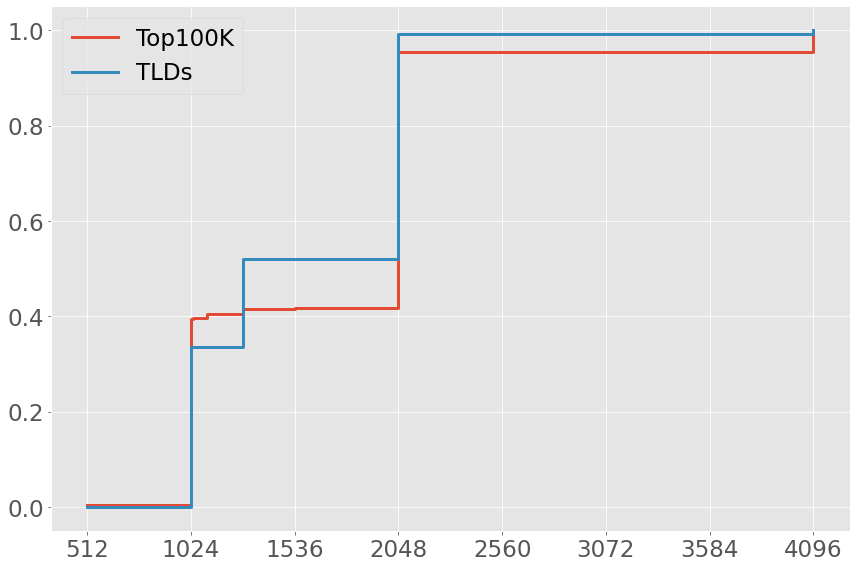

In [31]:
xticks = [512, 1024, 2048, 4096]
xticks = [512*v for v in range(1, 9)]
pdf_merged_dnskey_rsa_lengths_cdf_plot = pdf_merged_dnskey_rsa_lengths_cdf.plot.line(drawstyle='steps-post', xticks=xticks, subplots=False, sharex=True, sharey=True, linewidth=3, fontsize=23, figsize=(12,8))
pdf_merged_dnskey_rsa_lengths_cdf_plot.legend(loc=2, prop={'size': 23})
# pdf_merged_dnskey_rsa_lengths_cdf_plot.set_xticklabels(pdf_merged_dnskey_rsa_lengths_cdf_plot.get_xticklabels(), rotation = 45, ha="right")
pdf_merged_dnskey_rsa_lengths_cdf_plot.get_figure().tight_layout()
pdf_merged_dnskey_rsa_lengths_cdf_plot.get_figure().savefig(STATS_DIR + '/pdf_merged_dnskey_rsa_lengths_cdf_plot.pdf', format='pdf')

#### Print Table with Numbers

In [32]:
pdf_merged_dnskey_rsa_lengths_abs
caption = "Absolute numbers of DNSKEY records carrying RSA material, as found in Top100K domains and TLDs."
pdf_merged_dnskey_rsa_lengths_abs.to_latex(buf=STATS_DIR + '/pdf_merged_dnskey_rsa_lengths_abs.tex', float_format='{:.2%}'.format, caption=caption, )
pdf_merged_dnskey_rsa_lengths_abs

,Top100K,TLDs
512,31,0
1024,2353,1161
1032,5,1
1104,53,0
1152,3,0
1280,63,635
1304,3,0
1536,9,0
2024,2,0
2048,3237,1635


### CDF of Distinct Algorithms per Domain
*number of distinct algorithms per domain found in DNSKEY records*

#### Recall Data Format

In [33]:
# pdf_tlds_dnskey
pdf_top100k_dnskey

,owner_name,ttl,rclass,rtype,algorithm,flags,protocol,public_key,spec_id,spec_key_length,spec_usage
0,europa.eu.,313,IN,DNSKEY,rsasha256,256,3,AwEAAaRm9SpK2QM+wXxIeLqn3YvFZTl7eZM9vTgV4jbMIj...,61458,2048,zsk
1,europa.eu.,313,IN,DNSKEY,rsasha256,256,3,AwEAAbzwGZE2vZI6TKx32QmwUnsHtda7/6BOcNQPeJOLJU...,30858,2048,zsk
2,europa.eu.,313,IN,DNSKEY,rsasha256,257,3,AwEAAd6ILwCObzteZw4iDDFF5Ab0GGaEvtogmEvjNeZyjc...,14845,4096,ksk
3,nih.gov.,5702,IN,DNSKEY,rsasha1nsec3sha1,256,3,AwEAAbN3M1UHyllUVouAT7wMqO6CRhSbFzXf+2iWyecCfv...,32615,1024,zsk
4,nih.gov.,5702,IN,DNSKEY,rsasha1nsec3sha1,256,3,AwEAAfZmlMD7MzozFDRg1/V84TUDiWWh9mmVw4H9Iuc9Ax...,11360,1024,zsk
...,...,...,...,...,...,...,...,...,...,...,...
12831,munpia.com.,3278,IN,DNSKEY,ecdsap256sha256,256,3,oJMRESz5E4gYzS/q6XDrvU1qMPYIjCWzJaOau8XNEZeqCY...,34505,256,zsk
12832,dingoland.ir.,3600,IN,DNSKEY,ecdsap256sha256,257,3,mdsswUyr3DPW132mOi8V9xESWE8jTo0dxCjjnopKl+GqJx...,2371,256,ksk
12833,dingoland.ir.,3600,IN,DNSKEY,ecdsap256sha256,256,3,oJMRESz5E4gYzS/q6XDrvU1qMPYIjCWzJaOau8XNEZeqCY...,34505,256,zsk
12834,loeildelaphotographie.com.,8463,IN,DNSKEY,rsasha1nsec3sha1,256,3,AwEAAcm2N3UWtpuyUdkMgAv4wDvBpCQ6XKDgKSto8VqgaB...,13802,1024,zsk


#### Select Only the Relevant Data

In [34]:
pdf_top100k_algos = pdf_top100k_dnskey[['owner_name', 'algorithm']].drop_duplicates()
# pdf_top100k_algos = pdf_top100k_algos[pdf_top100k_algos['algorithm'].apply(lambda v: v not in {'dsa', 'privatedns'})]
pdf_tlds_algos = pdf_tlds_dnskey[['owner_name', 'algorithm']].drop_duplicates()
# pdf_tlds_algos = pdf_tlds_algos[pdf_tlds_algos['algorithm'].apply(lambda v: v not in {'dsa', 'privatedns'})]# 
pdf_top100k_algos
# pdf_tlds_algos

# pdf_top100k_algos = pdf_top100k_ds[['owner_name', 'algorithm']].drop_duplicates()
## pdf_top100k_algos = pdf_top100k_algos[pdf_top100k_algos['algorithm'].apply(lambda v: v not in {'dsa', 'privatedns'})]
# pdf_tlds_algos = pdf_tlds_ds[['owner_name', 'algorithm']].drop_duplicates()
## pdf_tlds_algos = pdf_tlds_algos[pdf_tlds_algos['algorithm'].apply(lambda v: v not in {'dsa', 'privatedns'})]
# pdf_top100k_algos
## pdf_tlds_algos

,owner_name,algorithm
0,europa.eu.,rsasha256
3,nih.gov.,rsasha1nsec3sha1
6,paypal.com.,rsasha1
8,cloudflare.com.,ecdsap256sha256
10,creativecommons.org.,ecdsap256sha256
...,...,...
12826,mattnordhoff.net.,ecdsap256sha256
12828,parasoft.com.,rsasha512
12830,munpia.com.,ecdsap256sha256
12832,dingoland.ir.,ecdsap256sha256


#### Count Unique Algorithms per Domain

In [35]:
pdf_top100k_algos_counts = pdf_top100k_algos.groupby('owner_name').count()
pdf_tlds_algos_counts = pdf_tlds_algos.groupby('owner_name').count()
pdf_top100k_algos_counts.reset_index(inplace=True)
pdf_tlds_algos_counts.reset_index(inplace=True)
# pdf_top100k_algos_counts
pdf_tlds_algos_counts


,owner_name,algorithm
0,aaa.,1
1,aarp.,1
2,abarth.,1
3,abb.,1
4,abbott.,1
...,...,...
1375,zara.,1
1376,zero.,1
1377,zip.,1
1378,zone.,1


#### Count Domains per Algorithm Count

In [36]:
pdf_top100k_algos_counts_abs = pdf_top100k_algos_counts.groupby('algorithm').count()
pdf_tlds_algos_counts_abs = pdf_tlds_algos_counts.groupby('algorithm').count()
# pdf_top100k_algos_counts_abs.reset_index(inplace=True)
# pdf_tlds_algos_counts_abs.reset_index(inplace=True)
# pdf_top100k_algos_counts_abs
pdf_tlds_algos_counts_abs

,owner_name
algorithm,
1,1374
2,6


#### Merge TLDs and Top 100k Stats

In [37]:
pdf_merged_dnskey_algos_counts_abs = pd.merge(left=pdf_top100k_algos_counts_abs, right=pdf_tlds_algos_counts_abs, how="outer", left_index=True, right_index=True, suffixes=['_top100k', '_tlds'])
pdf_merged_dnskey_algos_counts_abs.fillna(0, inplace=True)
pdf_merged_dnskey_algos_counts_abs = pdf_merged_dnskey_algos_counts_abs.astype(np.int64)
pdf_merged_dnskey_algos_counts_abs.columns = ["Top100K", "TLDs"]
pdf_merged_dnskey_algos_counts_abs.to_csv(DATA_DIR + "/pdf_merged_dnskey_algos_counts_abs.csv", index_label="Algorithms")
pdf_merged_dnskey_algos_counts_abs

# pdf_merged_ds_algos_counts_abs = pd.merge(left=pdf_top100k_algos_counts_abs, right=pdf_tlds_algos_counts_abs, how="outer", left_index=True, right_index=True, suffixes=['_top100k', '_tlds'])
# pdf_merged_ds_algos_counts_abs.fillna(0, inplace=True)
# pdf_merged_ds_algos_counts_abs = pdf_merged_ds_algos_counts_abs.astype(np.int64)
# pdf_merged_ds_algos_counts_abs.columns = ["Top100K", "TLDs"]
# pdf_merged_ds_algos_counts_abs.to_csv(STATS_DIR + "/pdf_merged_ds_algos_counts_abs.csv", index_label="Algorithms")
# pdf_merged_ds_algos_counts_abs

,Top100K,TLDs
algorithm,,
1,5688,1374
2,32,6
3,4,0
4,1,0


#### Make Columns Relative

In [38]:
pdf_merged_dnskey_algos_counts_rel = pdf_merged_dnskey_algos_counts_abs.copy(deep=True)
pdf_merged_dnskey_algos_counts_rel['Top100K'] = pdf_merged_dnskey_algos_counts_rel['Top100K']/sum(pdf_merged_dnskey_algos_counts_rel['Top100K'])
pdf_merged_dnskey_algos_counts_rel['TLDs'] = pdf_merged_dnskey_algos_counts_rel['TLDs']/sum(pdf_merged_dnskey_algos_counts_rel['TLDs'])
# pdf_merged_dnskey_algos_counts_rel = pdf_merged_dnskey_algos_counts_rel[::-1]
pdf_merged_dnskey_algos_counts_rel


,Top100K,TLDs
algorithm,,
1,0.993537,0.995652
2,0.005590,0.004348
3,0.000699,0.000000
4,0.000175,0.000000


#### Create CDF from Relatives

In [39]:
pdf_merged_dnskey_algos_counts_cdf = pdf_merged_dnskey_algos_counts_rel.copy(deep=True)
pdf_merged_dnskey_algos_counts_cdf['Top100K'] = pdf_merged_dnskey_algos_counts_cdf['Top100K'].cumsum()
pdf_merged_dnskey_algos_counts_cdf['TLDs'] = pdf_merged_dnskey_algos_counts_cdf['TLDs'].cumsum()
pdf_merged_dnskey_algos_counts_cdf.index = pdf_merged_dnskey_algos_counts_cdf.index.rename("Algorithm Count")
pdf_merged_dnskey_algos_counts_cdf

,Top100K,TLDs
Algorithm Count,,
1,0.993537,0.995652
2,0.999127,1.000000
3,0.999825,1.000000
4,1.000000,1.000000


#### Plot and Print Numbers to Table

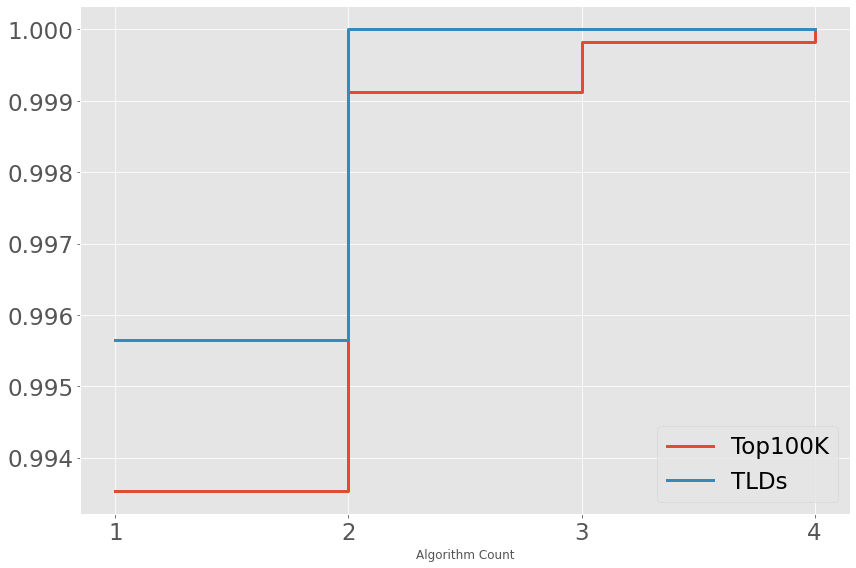

In [40]:
# xticks = [str(i) for i in reversed(range(1, pdf_merged_dnskey_algos_counts_cdf.index.max() + 1))]
xticks = range(1, pdf_merged_dnskey_algos_counts_cdf.index.max() + 1)
pdf_merged_dnskey_algos_counts_rel.index = pdf_merged_dnskey_algos_counts_rel.index.astype(str)
pdf_merged_dnskey_algos_counts_cdf_plot = pdf_merged_dnskey_algos_counts_cdf.plot.line(drawstyle='steps-post', xticks=xticks, subplots=False, sharex=True, sharey=True, linewidth=3, fontsize=23, figsize=(12,8))
pdf_merged_dnskey_algos_counts_cdf_plot.legend(loc=4, prop={'size': 23})
pdf_merged_dnskey_algos_counts_cdf_plot.get_figure().tight_layout()
# pdf_merged_dnskey_algos_counts_cdf_plot.invert_xaxis()
pdf_merged_dnskey_algos_counts_cdf_plot.get_figure().savefig(STATS_DIR + '/pdf_merged_dnskey_algos_counts_cdf_plot.pdf', format='pdf')
caption = "Absolute Numbers of Domains and their Distinct Algorithm Counts"
pdf_merged_dnskey_algos_counts_abs.to_latex(buf=STATS_DIR + '/pdf_merged_dnskey_algos_counts_abs.tex', float_format='{:.2%}'.format, caption=caption)

### Numbers of Distinct Algorithms Per Domain II
*observing down to the level of ciphers, digests and key lengths*

In [41]:
DIGEST_MD5 = 'md5'
DIGEST_SHA1 = 'sha1'
DIGEST_SHA256 = 'sha256'
DIGEST_SHA384 = 'sha384'
DIGEST_SHA512 = 'sha512'
DIGEST_SHA3 = 'sha3'

CIPHER_RSA = 'rsa'
CIPHER_DSA = 'dsa'
CIPHER_ECDSA = 'ecdsa'
CIPHER_EDDSA = 'eddsa'


CIPHER_NAMES_LEGAL = {
    'rsamd5',
    'dsa',
    'rsasha1',
    "dsansec3sha1",
    'rsasha1nsec3sha1',
    'rsasha256', 
    'rsasha512',
    'ecdsap256sha256', 
    'ecdsap384sha384', 
    'ed25519',
    'ed448',
}
ALGO_NAME_TO_CIPHER = {
    'rsamd5': CIPHER_RSA,
    'dsa': CIPHER_DSA,
    'rsasha1': CIPHER_RSA,
    "dsansec3sha1": CIPHER_DSA,
    'rsasha1nsec3sha1': CIPHER_RSA,
    'rsasha256': CIPHER_RSA, 
    'rsasha512': CIPHER_RSA,
    'ecdsap256sha256': CIPHER_ECDSA, 
    'ecdsap384sha384': CIPHER_ECDSA, 
    'ed25519': CIPHER_EDDSA,
    'ed448': CIPHER_EDDSA,
    # 'privatedns': 'privatedns'
}

CIPHER_NAME_TO_DIGEST = {
    'rsamd5': DIGEST_MD5,
    'dsa': DIGEST_SHA1,
    'rsasha1': DIGEST_SHA1,
    "dsansec3sha1": DIGEST_SHA1,
    'rsasha1nsec3sha1': DIGEST_SHA1,
    'rsasha256': DIGEST_SHA256, 
    'rsasha512': DIGEST_SHA512,
    'ecdsap256sha256': DIGEST_SHA256, 
    'ecdsap384sha384': DIGEST_SHA384, 
    'ed25519': DIGEST_SHA512,  # digest chosen according to https://en.wikipedia.org/wiki/EdDSA
    'ed448': DIGEST_SHA3,  # digest chosen according to https://en.wikipedia.org/wiki/EdDSA
    # 'privatedns': 'privatedns'
}

In [42]:
pdf_tlds_dnskey
# pdf_top100k_dnskey
# pdf_top100k_dnskey[ (pdf_top100k_dnskey['algorithm'] == 'ecdsap256sha256') | (pdf_top100k_dnskey['algorithm'] == 'ecdsap384sha384') ][['algorithm', 'spec_key_length']].groupby('algorithm').nunique()

,owner_name,ttl,rclass,rtype,algorithm,flags,protocol,public_key,spec_id,spec_key_length,spec_usage
0,aaa.,3069,IN,DNSKEY,rsasha256,256,3,AwEAAaZo2PfcnuHG+fTtOv+dlGmcaXMx9nnTZADUdZ0DiM...,20983,1024,zsk
1,aaa.,3069,IN,DNSKEY,rsasha256,256,3,AwEAAb12rqjDMXPoWc8Dy27iQL8yXUFG0RcofgFqtY1jb6...,13510,1024,zsk
2,aaa.,3069,IN,DNSKEY,rsasha256,256,3,AwEAAcE8Hq2/8vrhkGEoGAzjrOg1hOT7Dw5tXdZUPIBCYa...,1569,1280,zsk
3,aaa.,3069,IN,DNSKEY,rsasha256,256,3,AwEAAcLnWJQH2nFnnjdwKr4pNSRQQrU300nt3BxCfxGZqk...,44908,1024,zsk
4,aaa.,3069,IN,DNSKEY,rsasha256,257,3,AwEAAdP0u7lPitKr5iXKatPvzmQzp4lYfJulzSwF6aNH5N...,1657,2048,ksk
...,...,...,...,...,...,...,...,...,...,...,...
3543,zone.,76674,IN,DNSKEY,rsasha256,256,3,AwEAAaQDRs2XhuvJFlXxo0DsLIke4DOnK3LyEKpF8oZ1qo...,29769,1280,zsk
3544,zuerich.,3432,IN,DNSKEY,rsasha256,256,3,AwEAAc2MJ1mM4LvbmGkZq6wZe0rH3PV7tggp3A4XnGmOK0...,1189,1024,zsk
3545,zuerich.,3432,IN,DNSKEY,rsasha256,256,3,AwEAAdU/H1bShRjgpkoBudUbHtYeju9UcKtoZsIzUAyFyp...,56983,1024,zsk
3546,zuerich.,3432,IN,DNSKEY,rsasha256,256,3,AwEAAecOdYiObn9+R3bM2GlY1w4zw4TQslWIRpwpQtygjI...,13819,1024,zsk


#### Reduce PDF of requests to the Necessities

In [43]:
pdf_top100k_dnskey_reduced = pdf_top100k_dnskey[['owner_name', 'algorithm', 'spec_key_length']]
pdf_top100k_dnskey_reduced = pdf_top100k_dnskey_reduced[pdf_top100k_dnskey_reduced['algorithm'].isin(CIPHER_NAMES_LEGAL)]
pdf_top100k_dnskey_reduced

pdf_tlds_dnskey_reduced = pdf_tlds_dnskey[['owner_name', 'algorithm', 'spec_key_length']]
pdf_tlds_dnskey_reduced = pdf_tlds_dnskey_reduced[pdf_tlds_dnskey_reduced['algorithm'].isin(CIPHER_NAMES_LEGAL)]
pdf_tlds_dnskey_reduced

,owner_name,algorithm,spec_key_length
0,aaa.,rsasha256,1024
1,aaa.,rsasha256,1024
2,aaa.,rsasha256,1280
3,aaa.,rsasha256,1024
4,aaa.,rsasha256,2048
...,...,...,...
3543,zone.,rsasha256,1280
3544,zuerich.,rsasha256,1024
3545,zuerich.,rsasha256,1024
3546,zuerich.,rsasha256,1024


#### Number of DNSKEY-Domains

In [44]:
print("Number of Top100k Domains that feature a DNSKEY record: {}".format(pdf_top100k_dnskey_reduced['owner_name'].nunique()))
print("Number of TLDS that feature a DNSKEY record: {}".format(pdf_tlds_dnskey_reduced['owner_name'].nunique()))

Number of Top100k Domains that feature a DNSKEY record: 5721
Number of TLDS that feature a DNSKEY record: 1380


#### Derive Cipher and Digest from Algorithm Identifier

In [45]:
pdf_top100k_dnskey_extended = pdf_top100k_dnskey_reduced.copy(deep=True)
pdf_top100k_dnskey_extended['cipher'] = pdf_top100k_dnskey_extended.apply(lambda row: ALGO_NAME_TO_CIPHER[row['algorithm']], axis=1)
pdf_top100k_dnskey_extended['digest'] = pdf_top100k_dnskey_extended.apply(lambda row: CIPHER_NAME_TO_DIGEST[row['algorithm']], axis=1)
pdf_top100k_dnskey_extended

pdf_tlds_dnskey_extended = pdf_tlds_dnskey_reduced.copy(deep=True)
pdf_tlds_dnskey_extended['cipher'] = pdf_tlds_dnskey_extended.apply(lambda row: ALGO_NAME_TO_CIPHER[row['algorithm']], axis=1)
pdf_tlds_dnskey_extended['digest'] = pdf_tlds_dnskey_extended.apply(lambda row: CIPHER_NAME_TO_DIGEST[row['algorithm']], axis=1)
pdf_tlds_dnskey_extended

,owner_name,algorithm,spec_key_length,cipher,digest
0,aaa.,rsasha256,1024,rsa,sha256
1,aaa.,rsasha256,1024,rsa,sha256
2,aaa.,rsasha256,1280,rsa,sha256
3,aaa.,rsasha256,1024,rsa,sha256
4,aaa.,rsasha256,2048,rsa,sha256
...,...,...,...,...,...
3543,zone.,rsasha256,1280,rsa,sha256
3544,zuerich.,rsasha256,1024,rsa,sha256
3545,zuerich.,rsasha256,1024,rsa,sha256
3546,zuerich.,rsasha256,1024,rsa,sha256


#### Number of Domains with more than one Key

In [46]:
pdf_top100k_dnskey_numkeys = pdf_top100k_dnskey_extended.groupby('owner_name').count()
print("Number of Top100K domains with more than one/two Keys: {}, {}".format(
    len(pdf_top100k_dnskey_numkeys[pdf_top100k_dnskey_numkeys['algorithm']>1]),
    len(pdf_top100k_dnskey_numkeys[pdf_top100k_dnskey_numkeys['algorithm']>2])
))

pdf_tlds_dnskey_numkeys = pdf_tlds_dnskey_extended.groupby('owner_name').count()
print("Number of tlds with more than one/two Keys: {}, {}".format(
    len(pdf_tlds_dnskey_numkeys[pdf_tlds_dnskey_numkeys['algorithm']>1]),
    len(pdf_tlds_dnskey_numkeys[pdf_tlds_dnskey_numkeys['algorithm']>2])
))

pdf_top100k_dnskey_numkeys

Number of Top100K domains with more than one/two Keys: 5328, 1174
Number of tlds with more than one/two Keys: 1380, 476


,algorithm,spec_key_length,cipher,digest
owner_name,,,,
000webhost.com.,2,2,2,2
0daymusic.org.,2,2,2,2
1-xbet0860301.top.,2,2,2,2
1-xbet3563544.top.,2,2,2,2
1001juegos.com.,2,2,2,2
...,...,...,...,...
zorgkaartnederland.nl.,2,2,2,2
zupimages.net.,2,2,2,2
zurb.com.,2,2,2,2


#### Number of Domains that support more than one distinct Cipher

In [47]:
pdf_top100k_dnskey_num_ciphers = pdf_top100k_dnskey_extended[['owner_name', 'cipher']].groupby('owner_name').nunique()
print("Number of Top100k domains with more than one distinct cipher: {}".format(
    len(pdf_top100k_dnskey_num_ciphers[pdf_top100k_dnskey_num_ciphers['cipher'] > 1])
))
# pdf_top100k_dnskey_num_ciphers[pdf_top100k_dnskey_num_ciphers['cipher'] > 1]

pdf_tlds_dnskey_num_ciphers = pdf_tlds_dnskey_extended[['owner_name', 'cipher']].groupby('owner_name').nunique()
print("Number of TLDS with more than one distinct cipher: {}".format(
    len(pdf_tlds_dnskey_num_ciphers[pdf_tlds_dnskey_num_ciphers['cipher'] > 1])
))
# pdf_top100k_dnskey_num_ciphers[pdf_top100k_dnskey_num_ciphers['cipher'] > 1]

Number of Top100k domains with more than one distinct cipher: 18
Number of TLDS with more than one distinct cipher: 0


#### Number of Domains that support more than one key length with the same cipher

In [48]:
pdf_top100k_dnskey_num_keylengths = pdf_top100k_dnskey_extended[['owner_name', 'cipher', 'spec_key_length']].groupby(['owner_name', 'cipher']).nunique()
pdf_top100k_dnskey_num_keylengths_differents = pdf_top100k_dnskey_num_keylengths[pdf_top100k_dnskey_num_keylengths['spec_key_length'] > 1]
pdf_top100k_dnskey_num_keylengths_differents = pdf_top100k_dnskey_num_keylengths_differents.reset_index()[['owner_name', 'spec_key_length']].drop_duplicates()

print("Number of Top100k Domains with more than one distinct key length with at least one cipher: {}".format(
    len(pdf_top100k_dnskey_num_keylengths_differents)
))
# pdf_top100k_dnskey_num_keylengths[pdf_top100k_dnskey_num_keylengths['spec_key_length'] > 1]

pdf_tlds_dnskey_num_keylengths = pdf_tlds_dnskey_extended[['owner_name', 'cipher', 'spec_key_length']].groupby(['owner_name', 'cipher']).nunique()
pdf_tlds_dnskey_num_keylengths_differents = pdf_tlds_dnskey_num_keylengths[pdf_tlds_dnskey_num_keylengths['spec_key_length'] > 1]
pdf_tlds_dnskey_num_keylengths_differents = pdf_tlds_dnskey_num_keylengths_differents.reset_index()[['owner_name', 'spec_key_length']].drop_duplicates()

print("Number of tlds with more than one distinct key length with at least one cipher: {}".format(
    len(pdf_tlds_dnskey_num_keylengths_differents)
))


Number of Top100k Domains with more than one distinct key length with at least one cipher: 1652
Number of tlds with more than one distinct key length with at least one cipher: 1200


#### Number of Domains that support more than one hash algorithm with the same cipher

In [49]:
pdf_top100k_dnskey_num_digests = pdf_top100k_dnskey_extended[['owner_name', 'cipher', 'digest']].groupby(['owner_name', 'cipher']).nunique()
pdf_top100k_dnskey_num_digests_differents = pdf_top100k_dnskey_num_digests[pdf_top100k_dnskey_num_digests['digest'] > 1]
pdf_top100k_dnskey_num_digests_differents = pdf_top100k_dnskey_num_digests_differents.reset_index()[['owner_name', 'digest']].drop_duplicates()

print("Number of Top100k Domains with more than one digest with the same cipher: {}". format(
    # len(pdf_top100k_dnskey_num_digests[pdf_top100k_dnskey_num_digests['digest'] > 1])
    len(pdf_top100k_dnskey_num_digests_differents)
))


pdf_tlds_dnskey_num_digests = pdf_tlds_dnskey_extended[['owner_name', 'cipher', 'digest']].groupby(['owner_name', 'cipher']).nunique()
pdf_tlds_dnskey_num_digests_differents = pdf_tlds_dnskey_num_digests[pdf_tlds_dnskey_num_digests['digest'] > 1]
pdf_tlds_dnskey_num_digests_differents = pdf_tlds_dnskey_num_digests_differents.reset_index()[['owner_name', 'digest']].drop_duplicates()

print("Number of tlds with more than one digest with the same cipher: {}". format(
    len(pdf_tlds_dnskey_num_digests_differents)
))


Number of Top100k Domains with more than one digest with the same cipher: 24
Number of tlds with more than one digest with the same cipher: 6
